In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import transforms, datasets

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # to set the device as cuda supported gpu if available

In [3]:
transform = transforms.Compose([transforms.Resize((28, 28)), # to resize the image into 28 * 28 resolution
                                transforms.ToTensor(), # to convert into tensor and also scale between 0 to 1
                                transforms.Normalize((0.5,), (0.5,)) # this normalizes the pixel values by setting mean, std = 0.5.
                                ])

training_dataset = datasets.MNIST(root='./data', train = True, download = True, transform=transform)
validation_dataset = datasets.MNIST(root='./data', train = False, download = True, transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size = 100, shuffle= True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle= True)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
dataiter = iter(training_loader)
images, labels = dataiter.next()

In [32]:
def im_convert(tensor):
    image = tensor.cpu().clone().detach().numpy() # a note on the detach function below
    image = image.transpose(1,2,0) # swaps the places of the channels, the first would be moved to last, giving is (28, 28, 1)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5)) 
    image = image.clip(0, 1) # forcibly squashes the value to range between 0 and 1
    return image

**tensor.detach()** creates a tensor that shares storage with tensor that does not require grad. It detaches the output from the computational graph. So no gradient will be backpropagated along this variable.

The wrapper with **torch.no_grad()** temporarily set all the ***requires_grad*** flag to false. ***torch.no_grad*** says that no operation should build the graph.

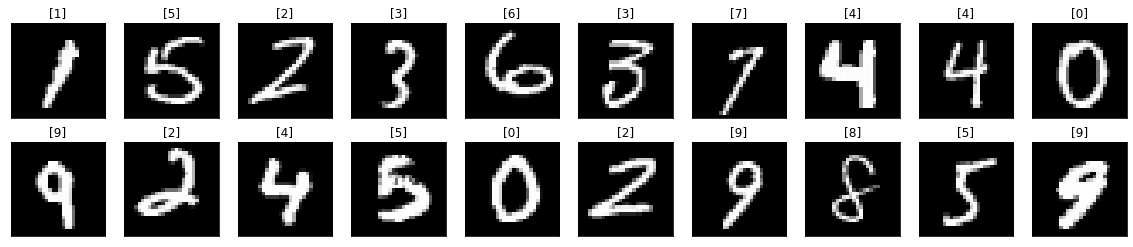

In [6]:
fig = plt.figure(figsize=(20, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title([labels[idx].item()])

This time we will define a LeNet

![image](https://www.researchgate.net/profile/Yiren_Zhou/publication/312170477/figure/fig1/AS:448817725218816@1484017892071/Structure-of-LeNet-5.png)

In [7]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        # adding the first two dense layers
        self.conv1 = nn.Conv2d(1, 20, 5, 1) # 1 is the channel, 20 filters, 5 is filter size, 1 is the stride
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        # defining the dense layers and dropout
        self.fc1 = nn.Linear(4*4*50, 500) # the input to dense is 4*4*50 as 4*4 would be output image shape from Conv layers.
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        # print(x.shape)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        return x

In [8]:
model = LeNet()
if torch.cuda.is_available():
    model.cuda()
model

LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [10]:
epochs = 20
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

# going through each epoch
for e in range(epochs):
    running_loss = 0
    running_corrects = 0 
    val_running_loss = 0
    val_running_corrects = 0

    # going through each batch
    for inputs, labels in training_loader:
        # inputs = inputs.view(inputs.shape[0], -1) we don't need these layers as we don't need 1D array initially for Conv.
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # calculating the prediction by getting the max probability class
        _, preds = torch.max(outputs, 1)

        # adding the losses for the batches
        running_loss += loss.item()
        # adding the accuracy for the batches
        running_corrects += torch.sum(preds == labels.data)

    else:

        # calculating the same metrics as above for validation set
        with torch.no_grad():
            for val_inputs, val_labels in validation_loader:
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)
                # val_inputs = val_inputs.view(val_inputs.shape[0], -1)
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)

                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels.data)

        # calculating the epoch loss
        epoch_loss = running_loss / len(training_loader)
        # calculating the epoch accuracy
        epoch_acc = running_corrects.float() / len(training_loader)

        running_loss_history.append(epoch_loss)
        running_corrects_history.append(epoch_acc)

        # calculating epoch loss and accuracy for validation set
        val_epoch_loss = val_running_loss / len(validation_loader)
        val_epoch_acc = val_running_corrects / len(validation_loader)
        val_running_loss_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_acc)
        print('Epoch: ', (e+1))
        print('Training Loss: {:.4f}, Accuracy: {:.4f}'.format(epoch_loss, epoch_acc.item()))
        print('Validation Loss: {:4f}, Validation Accuracy: {:.4f}'.format(val_epoch_loss, val_epoch_acc.item()))

Epoch:  1
Training Loss: 0.5868, Accuracy: 83.9083
Validation Loss: 0.185839, Validation Accuracy: 94.4600
Epoch:  2
Training Loss: 0.1544, Accuracy: 95.3917
Validation Loss: 0.109093, Validation Accuracy: 96.6400
Epoch:  3
Training Loss: 0.1047, Accuracy: 96.9050
Validation Loss: 0.077840, Validation Accuracy: 97.5600
Epoch:  4
Training Loss: 0.0822, Accuracy: 97.5033
Validation Loss: 0.065733, Validation Accuracy: 98.0600
Epoch:  5
Training Loss: 0.0676, Accuracy: 97.9250
Validation Loss: 0.055133, Validation Accuracy: 98.3800
Epoch:  6
Training Loss: 0.0591, Accuracy: 98.2100
Validation Loss: 0.053782, Validation Accuracy: 98.2800
Epoch:  7
Training Loss: 0.0518, Accuracy: 98.4350
Validation Loss: 0.043767, Validation Accuracy: 98.6600
Epoch:  8
Training Loss: 0.0462, Accuracy: 98.6283
Validation Loss: 0.039095, Validation Accuracy: 98.8000
Epoch:  9
Training Loss: 0.0429, Accuracy: 98.6783
Validation Loss: 0.038637, Validation Accuracy: 98.7100
Epoch:  10
Training Loss: 0.0376, Acc

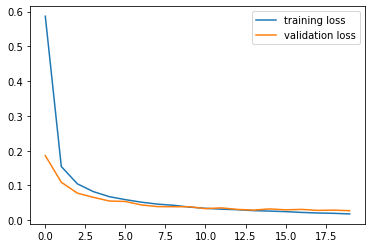

In [11]:
plt.plot(running_loss_history, label = 'training loss')
plt.plot(val_running_loss_history, label = 'validation loss')
plt.legend()
plt.show()

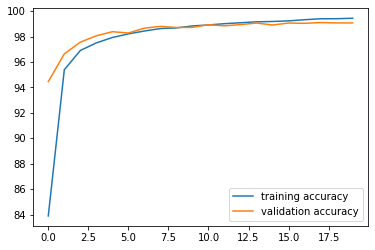

In [12]:
plt.plot(running_corrects_history, label = 'training accuracy')
plt.plot(val_running_corrects_history, label = 'validation accuracy')
plt.legend()
plt.show()

We can now try with a random image from the internet to validate out model.

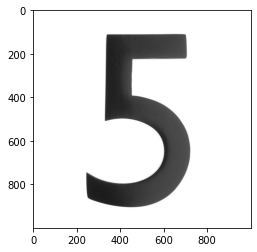

In [33]:
import PIL.ImageOps
import requests
from PIL import Image

url = 'https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img);

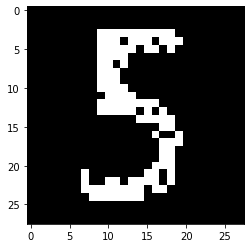

In [34]:
# We have to transform out image so be similar to the ones we have in the MNIST training set.
img = PIL.ImageOps.invert(img) # inverting the background and foreground
img = img.convert('1') # converts the image into binarized like b/w image
img = transform(img)
plt.imshow(im_convert(img))

In [35]:
# feeding it to the model and getting the output
images = img.to(device)
image = images[0].unsqueeze(0).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(pred.item())

5


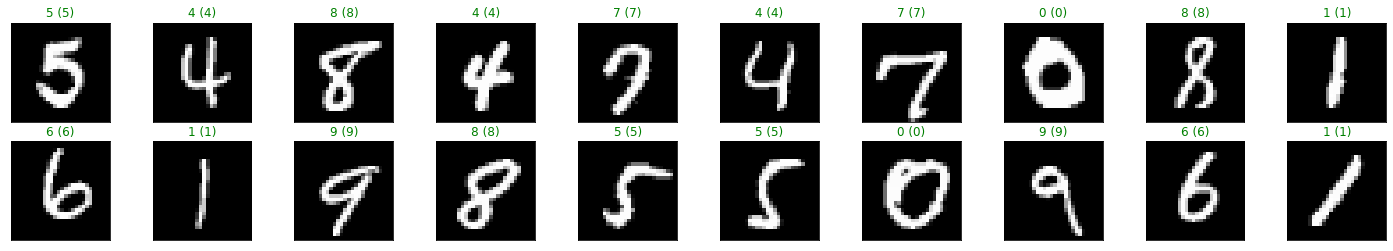

In [36]:

dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color=("green" if preds[idx]==labels[idx] else "red"))